## Imports

In [27]:
import altair as alt

import numpy as np
import pandas as pd
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

# Data Analysis for Sensor Location 716

![title](sensorLocation716.png)

# Raw Data Analysis for 2019-04-01

## Data Loading and Parsing

In [16]:
sds011_data = pd.read_csv("../data/raw/analysis/2019-04-01_sds011_sensor_1444.csv", sep=";")

In [22]:
sds011_data["timestamp"] = pd.to_datetime(sds011_data["timestamp"])

In [17]:
dht22_data = pd.read_csv("../data/raw/analysis/2019-04-01_dht22_sensor_1445.csv", sep=";")

In [23]:
dht22_data["timestamp"] = pd.to_datetime(dht22_data["timestamp"])

In [24]:
sds011_data.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,P1,durP1,ratioP1,P2,durP2,ratioP2
0,1444,SDS011,716,52.496,13.338,2019-04-01 00:00:14,4.12,NaN,NaN,2.17,NaN,NaN
1,1444,SDS011,716,52.496,13.338,2019-04-01 00:03:16,5.33,NaN,NaN,1.82,NaN,NaN
2,1444,SDS011,716,52.496,13.338,2019-04-01 00:05:45,3.17,NaN,NaN,1.65,NaN,NaN
3,1444,SDS011,716,52.496,13.338,2019-04-01 00:08:12,2.75,NaN,NaN,1.80,NaN,NaN
4,1444,SDS011,716,52.496,13.338,2019-04-01 00:10:40,2.83,NaN,NaN,1.75,NaN,NaN


In [25]:
dht22_data.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,temperature,humidity
0,1445,DHT22,716,52.496,13.338,2019-04-01 00:00:15,6.2,91.4
1,1445,DHT22,716,52.496,13.338,2019-04-01 00:03:17,6.2,91.9
2,1445,DHT22,716,52.496,13.338,2019-04-01 00:05:45,6.2,92.7
3,1445,DHT22,716,52.496,13.338,2019-04-01 00:08:13,6.2,92.6
4,1445,DHT22,716,52.496,13.338,2019-04-01 00:10:41,6.2,93.1


## Time Series for 2019-04-01

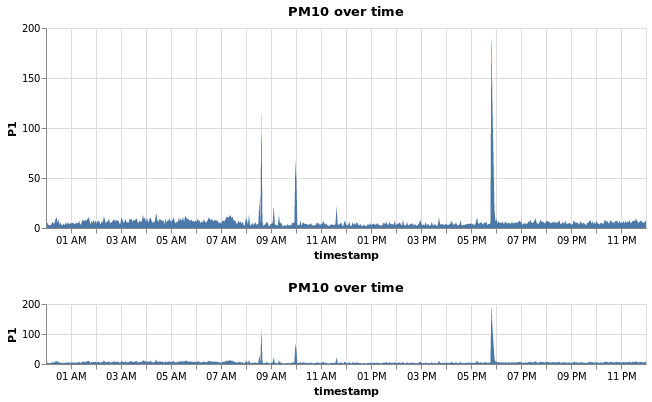

In [33]:
brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(sds011_data).mark_area().encode(
    alt.X('timestamp:T', scale=alt.Scale(domain=brush)),
    y='P1:Q'
).properties(
    width=600,
    height=200
).properties(
    title='PM10 over time'
)

lower = upper.properties(
    height=60
).add_selection(brush)

upper & lower

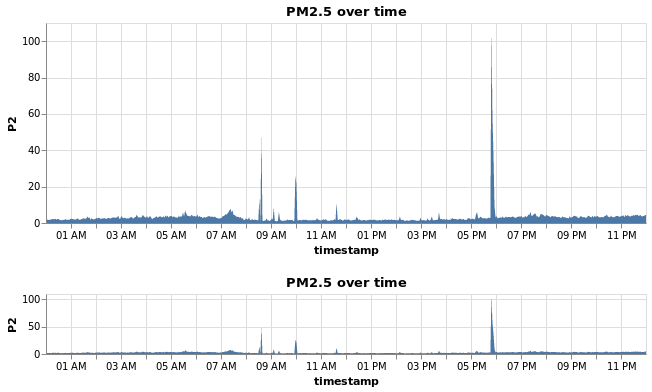

In [32]:
brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(sds011_data).mark_area().encode(
    alt.X('timestamp:T', scale=alt.Scale(domain=brush)),
    y='P2:Q'
).properties(
    width=600,
    height=200
).properties(
    title='PM2.5 over time'
)

lower = upper.properties(
    height=60
).add_selection(brush)

upper & lower

## Distribution of durations between sensor readings

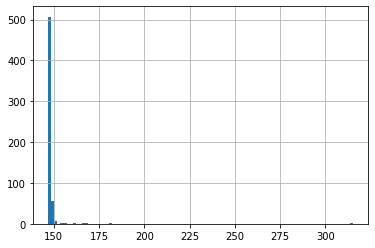

In [55]:
(sds011_data["timestamp"] - sds011_data.groupby("sensor_id").shift(1)["timestamp"]).dropna().apply(lambda x: x.total_seconds()).hist(bins=100)

As we can see, there is one measurement every 2.5 minutes. With a window size of 5 minutes, this results in usually two readings per window as can be seen below.

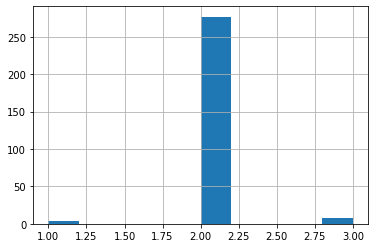

In [70]:
sds011_data["timestamp"].dt.round("5min", nonexistent="shift_backward").value_counts().hist()

For a window size of 10 minutes, this doubles to 4 readings.

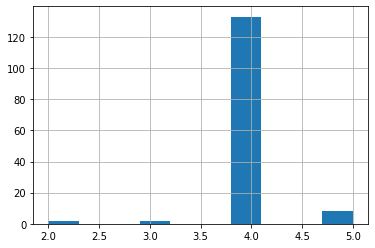

In [71]:
sds011_data["timestamp"].dt.round("10min", nonexistent="shift_backward").value_counts().hist()

## Aggregated Data (5, 10 minute windows)

In [2]:
def prepare_pd_dataframe():
    sensor_data = pd.read_csv("../data/processed/output.csv", sep=";", names=[
        "location", "lat", "lon", "timestamp", "dayOfYear", "minuteOfDay", "dayOfWeek", "isWeekend", "pressure", "altitude", "pressure_sealevel", "temperature",
        "humidity", "p1", "p2", "p0", "durP1", "ratioP1", "durP2", "ratioP2"], true_values=["true"], false_values=["false"])

    sensor_data["timestamp"] = pd.to_datetime(sensor_data["timestamp"])
    sensor_data["isWeekend"] = sensor_data["isWeekend"].astype(int)

    sensor_data = sensor_data.sort_values(by=["location", "timestamp"])
    return sensor_data

In [3]:
sensor_data = prepare_pd_dataframe()

In [4]:
sensor_716 = sensor_data[sensor_data["location"] == 716]

In [78]:
sensor_716.head()

,location,lat,lon,timestamp,dayOfYear,minuteOfDay,dayOfWeek,isWeekend,pressure,altitude,pressure_sealevel,temperature,humidity,p1,p2,p0,durP1,ratioP1,durP2,ratioP2
493276,716,52.496,13.338,2017-04-02 14:40:00,92,880,1,0,NaN,NaN,NaN,19.800000,45.933333,17.016667,14.940,NaN,NaN,NaN,0.0,0.0
556410,716,52.496,13.338,2017-04-02 14:45:00,92,885,1,0,NaN,NaN,NaN,19.640000,46.080000,16.712000,14.098,NaN,NaN,NaN,0.0,0.0
597676,716,52.496,13.338,2017-04-02 14:50:00,92,890,1,0,NaN,NaN,NaN,19.040000,45.660000,12.374000,10.916,NaN,NaN,NaN,0.0,0.0
597677,716,52.496,13.338,2017-04-02 14:55:00,92,895,1,0,NaN,NaN,NaN,18.720000,45.720000,10.062000,8.974,NaN,NaN,NaN,0.0,0.0
597678,716,52.496,13.338,2017-04-02 15:00:00,92,900,1,0,NaN,NaN,NaN,18.616667,45.566667,7.948333,7.115,NaN,NaN,NaN,0.0,0.0
